In [2]:
import pandas as pd
import pathlib
import gazel
import numpy as np
import collections
import seaborn as sns
import itertools
from tqdm.auto import tqdm

In [3]:
root = pathlib.Path("/Users/devjeetroy/Library/CloudStorage/OneDrive-Personal/Control-Experiment-Spring-2022")


## Fixation Filtering

### Load data

In [3]:
plugin_df = pd.read_csv("../../data/eyetracking/plugin.csv")
core_df = pd.read_csv("../../data/eyetracking/core.csv")

/var/folders/9t/pnh1mqks36vfw7ngs3d7n8r00000gn/T/ipykernel_96382/182331469.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  plugin_df = pd.read_csv("../../data/eyetracking/plugin.csv")


In [4]:
core_df.head()

,event_id,core_time,tracker_time,x,y,left_x,left_y,left_pupil_diameter,left_validation,right_x,...,right_pupil_diameter,right_validation,user_left_x,user_left_y,user_left_z,user_right_x,user_right_y,user_right_z,pid,tid
0,133149272566191330,1670453656618,4462814344663,246,333,255.5136,312.0768,19.42247,1,236.8128,...,18.65228,1,-0.03147,-0.01503,0.61457,0.02829,-0.01455,0.62168,p101,t2
1,133149272566192437,1670453656618,4462814411287,247,319,219.0144,315.8028,18.97429,1,275.6928,...,18.86123,1,-0.03147,-0.01503,0.61457,0.02829,-0.01455,0.62168,p101,t2
2,133149272566345304,1670453656634,4462814477722,253,323,263.9232,327.2400,19.11510,1,241.9776,...,19.38213,1,-0.03147,-0.01503,0.61457,0.02829,-0.01455,0.62168,p101,t2
3,133149272566346156,1670453656634,4462814550331,251,319,263.9232,327.2400,18.97301,1,237.5808,...,19.33631,1,-0.03170,-0.01505,0.61545,0.02891,-0.01489,0.63636,p101,t2
4,133149272566506460,1670453656650,4462814610289,221,308,229.6896,326.1060,19.03372,1,212.9856,...,19.40804,1,-0.03170,-0.01505,0.61545,0.02891,-0.01489,0.63636,p101,t2


### Processing code

In [5]:
def _fixation_to_dict(fixation: gazel.fixation_data.Fixation) -> dict:
    fixation.calculateDatebaseFields()
    fixation_fields = fixation.__dict__.copy()
    # del fixation_fields["gaze_set"]
    fixation_fields['gaze_set'] = [gaze.__dict__.copy() for gaze in fixation.gaze_set]

    return fixation_fields

def compute_fixations_itrace(core_df, plugin_df):
    for df, col in itertools.product([core_df, plugin_df], ['x', 'y']):
        df[col] = df[col].astype(int)
    raw_inputs = gazel.fixation_filters.core.create_gazes_for_fixation_filters(
        plugin_df, core_df)
    fixations = gazel.fixation_filters.IVT.run_filters(
        raw_inputs, gazel.fixation_filters.IVT.IVTConfig(50, 80))

    return list(map(_fixation_to_dict, fixations))


def apply_fixation_estimate_fix(fixations, frequency_threshold=1):
    fixed_fixations = []
    for fixation in fixations:
        fixation = fixation.copy()
        gazes = fixation['gaze_set']

        if fixation['source_file_line'] == -1:
            # check if any gazes have valid positions
            gaze_positions = [(gaze['source_file_line'],
                               gaze['source_file_col']) for gaze in gazes]
            fixation_pos = (fixation['source_file_line'],
                            fixation['source_file_col'])
            if any(-1 not in gaze for gaze in gaze_positions):
                # Find highest frequency position
                counts = collections.Counter(
                    [pos for pos in gaze_positions if -1 not in pos])
                (most_common, count) = counts.most_common(1)[0]
                if count >= frequency_threshold:
                    fixation = {
                        **fixation, "source_file_line": most_common[0],
                        "source_file_col": most_common[1]
                    }
        fixed_fixations.append(fixation)

    return fixed_fixations 

### Processing

In [6]:
core_groups = core_df.groupby(['pid', 'tid'])
plugin_groups = plugin_df.groupby(['pid', 'tid'])

itrace_fixation_dfs = []
fixed_fixation_dfs = []

all_group_keys = list(core_groups.groups.keys())
for group_key in tqdm(all_group_keys):
    task_core_df = core_groups.get_group(group_key)
    if group_key in plugin_groups.groups:
        try:
            task_plugin_df = plugin_groups.get_group(group_key)

            itrace_fixations = compute_fixations_itrace(task_core_df.copy(),
                                                        task_plugin_df.copy())
            fixed_fixations = apply_fixation_estimate_fix(itrace_fixations)

            itrace_fixations = pd.DataFrame(itrace_fixations).drop(
                'gaze_set', axis=1).copy()
            fixed_fixations = pd.DataFrame(fixed_fixations).drop(
                'gaze_set', axis=1).query("source_file_line >= 0").copy()

            itrace_fixations['pid'] = group_key[0]
            itrace_fixations['tid'] = group_key[1]

            fixed_fixations['pid'] = group_key[0]
            fixed_fixations['tid'] = group_key[1]

            itrace_fixation_dfs.append(itrace_fixations)
            fixed_fixation_dfs.append(fixed_fixations)

            break
        except Exception as e:
            print(f"Error processing {group_key}: {e}")


  0%|          | 0/348 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.9/site-packages/gazel/fixation_filters/core.py:65: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  entries = combined.to_dict("record")
  0%|          | 0/348 [00:08<?, ?it/s]


In [7]:

from typing import Optional


def interpolate_gazes(df: pd.DataFrame,
                      x: str,
                      y: str,
                      left_validation: Optional[str] = None,
                      right_validation: Optional[str] = None,
                      partial=False):
    # Interpolation
    # We want to interpolate gaze points as a whole,
    # and not just x & y independently
    df = df.copy()
    if partial:
        # forward fill x/y independently
        df[x] = df[x].fillna(method='ffill')
        df[y] = df[y].fillna(method='ffill')
    else:
        # forward fill entire rows
        invalid_xys = (df[x] < 0) | (df[y] < 0)
        df.loc[invalid_xys, :] = np.nan
        df = df.fillna(method='ffill')

    invalid_gazes = np.zeros(len(df), dtype=bool)
    if left_validation is not None:
        invalid_gazes = invalid_gazes | (df[left_validation] == 0)
    if right_validation is not None:
        invalid_gazes = invalid_gazes | (df[right_validation] == 0)

    return df[~invalid_gazes]


def ivt_gaze_classification(gazes: pd.DataFrame,
                            x: str = 'x',
                            y: str = 'y',
                            line: str = 'source_file_line',
                            col: str = 'source_file_col',
                            time: str = 'plugin_time',
                            left_validation: str = 'left_validation',
                            right_validation: str = 'right_validation',
                            velocity_threshold: float = 50,
                            duration_threshold: float = 80,
                            line_col_estimation_frequency_threshold: int = 1,
                            cols_to_average: list[str] = [
                                'left_pupil_diameter',
                                'right_pupil_diameter',
                            ],
                            constant_cols: list[str] = ['pid', 'tid', 'gaze_target']):
    gazes = interpolate_gazes(gazes, x, y, partial=False)
    is_valid = (gazes[x] >= 0) & (gazes[y] >=
                                  0) & (~gazes[x].isna()) & (~gazes[y].isna())
    # Compute velocity
    velocity: pd.Series = np.sqrt(gazes[x].diff()**2 +
                                  gazes[y].diff()**2).fillna(  # type: ignore
                                      0)
    is_fixation_point = velocity <= velocity_threshold
    fixation_groups = (is_fixation_point != is_fixation_point.shift()).cumsum()

    def compute_fixation_groups(df):
        duration = df[time].max() - df[time].min()

        positions = list(map(tuple, zip(df[x], df[y])))
        frequencies = collections.Counter(position for position in positions
                                          if -1 not in position)
        most_common, count = frequencies.most_common(1)[0]

        if duration >= duration_threshold and count >= line_col_estimation_frequency_threshold:
            return pd.DataFrame({
                'duration': [duration],
                'n': [len(df)],
                time: [df[time].min()],
                line: [most_common[0]],
                col: [most_common[1]],
                **{k: [df[k].iloc[0]] for k in constant_cols if k in df.columns},
                **{k: [df[k].mean()]
                   for k in (cols_to_average + [x, y]) if k in df.columns}
            })
        return pd.DataFrame()

    return gazes[is_valid & is_fixation_point].groupby(
        fixation_groups[is_valid
                        & is_fixation_point]).apply(compute_fixation_groups)

# merged = pd.merge(
#     task_core_df,
#     task_plugin_df,
#     on=list(task_core_df.columns.intersection(task_plugin_df.columns)),
#     how='inner')

# computed_fixations = ivt_gaze_classification(merged, time='plugin_time')
# computed_fixations = computed_fixations.rename({
#     'plugin_time': 'system_time',
#     'gaze_target': 'target',
# }, axis=1)

In [29]:
computed_fixations.columns

Index(['duration', 'n', 'plugin_time', 'source_file_line', 'source_file_col',
       'pid', 'tid', 'gaze_target', 'left_pupil_diameter',
       'right_pupil_diameter', 'x', 'y'],
      dtype='object')

,,duration,n,plugin_time,source_file_line,source_file_col,pid,tid,gaze_target,left_pupil_diameter,right_pupil_diameter,x,y
45,0,84.0,10.0,1.636745e+12,802.0,398.0,p10,t1,graph_utils_c.cc,14.377333,15.828283,822.300000,412.600000
67,0,116.0,15.0,1.636745e+12,655.0,455.0,p10,t1,graph_utils_c.cc,14.546060,18.455841,650.666667,444.733333
189,0,93.0,10.0,1.636745e+12,402.0,491.0,p10,t1,graph_utils_c.cc,15.337935,19.119728,369.700000,458.300000
237,0,107.0,13.0,1.636745e+12,255.0,443.0,p10,t1,graph_utils_c.cc,14.774688,17.352651,256.538462,425.461538
325,0,95.0,15.0,1.636745e+12,258.0,398.0,p10,t1,graph_utils_c.cc,17.127105,17.693210,251.600000,383.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13257,0,190.0,25.0,1.636745e+12,494.0,695.0,p10,t1,graph_utils_c.cc,15.720620,18.175006,492.280000,698.640000
13271,0,158.0,20.0,1.636745e+12,471.0,731.0,p10,t1,graph_utils_c.cc,15.759643,17.771248,439.950000,720.300000
13285,0,91.0,11.0,1.636745e+12,483.0,724.0,p10,t1,graph_utils_c.cc,15.409265,18.051853,464.272727,714.090909
13351,0,88.0,11.0,1.636745e+12,756.0,1105.0,p10,t1,graph_utils_c.cc,17.313065,16.897933,742.000000,1098.272727


In [22]:
# merged.query('plugin_time >= 1636744932140').head(20)[['plugin_time', 'x', 'y']]
itrace_fixation_dfs[0]

,x,y,target,source_file_line,source_file_col,syntactic_category,xpath,left_pupil_diameter,right_pupil_diameter,duration,token,fixation_event_time,system_time,pid,tid
0,822.300000,412.600000,graph_utils_c.cc,-1,-1,None,None,14.377333,15.828283,84,None,132812184057722486,1636744805772,p10,t1
1,650.666667,444.733333,graph_utils_c.cc,-1,-1,None,None,14.546060,18.455841,116,None,132812184062257176,1636744806225,p10,t1
2,369.700000,458.300000,graph_utils_c.cc,-1,-1,None,None,15.337935,19.119728,93,None,132812184085263310,1636744808527,p10,t1
3,256.538462,425.461538,graph_utils_c.cc,-1,-1,None,None,14.774688,17.352651,107,None,132812184095806309,1636744809580,p10,t1
4,251.600000,383.666667,graph_utils_c.cc,-1,-1,None,None,17.118131,17.751069,95,None,132812184114689057,1636744811468,p10,t1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,492.280000,698.640000,graph_utils_c.cc,-1,-1,None,None,15.720620,18.175006,190,None,132812187721064867,1636745172106,p10,t1
716,439.950000,720.300000,graph_utils_c.cc,-1,-1,None,None,15.759643,17.771248,158,None,132812187725167619,1636745172516,p10,t1
717,464.272727,714.090909,graph_utils_c.cc,-1,-1,None,None,15.409265,18.051853,91,None,132812187728499856,1636745172850,p10,t1
718,742.000000,1098.272727,graph_utils_c.cc,-1,-1,None,None,17.313065,16.897933,88,None,132812187741299702,1636745174130,p10,t1


### Save to csvs

In [142]:
pd.concat(itrace_fixation_dfs).to_csv("../../data/eyetracking/itrace_fixations.csv", index=False)
pd.concat(fixed_fixation_dfs).to_csv("../../data/eyetracking/fixed_fixations.csv", index=False)

## Gaze Metrics

In [178]:
fixations = pd.read_csv("../../data/eyetracking/fixed_fixations.csv")

all_tasks = fixations.groupby(['pid', 'tid'])
task_keys = list(all_tasks.groups.keys())


def is_regression(prev_pos, current_pos):
    prev_line, prev_col = prev_pos
    curr_line, curr_col = current_pos

    if curr_line < prev_line:
        return True
    if curr_line == prev_line and curr_col < prev_col:
        return True
    return False


def regression_rate(fixations):
    regressions = 0
    for prev, current in zip(fixations, fixations[1:]):
        if is_regression(
            (prev['source_file_line'], prev['source_file_col']),
            (current['source_file_line'], current['source_file_col'])):
            regressions += 1

    return regressions / len(fixations)


def line_regression_rate(fixations):
    regressions = 0
    for prev, current in zip(fixations, fixations[1:]):
        if prev['source_file_line'] == current[
                'source_file_line'] and is_regression(
                    (prev['source_file_line'], prev['source_file_col']),
                    (current['source_file_line'], current['source_file_col'])):
            regressions += 1

    return regressions / len(fixations)

def vertical_next(fixations):
    vertical = 0
    for prev, current in zip(fixations, fixations[1:]):
        line_diff = current['source_file_line'] - prev['source_file_line']
        if line_diff == 0 or line_diff == -1:
            vertical += 1
            
    return vertical / len(fixations)

def vertical_later(fixations):
    vertical = 0
    for prev, current in zip(fixations, fixations[1:]):
        if not is_regression(
            (prev['source_file_line'], prev['source_file_col']),
            (current['source_file_line'], current['source_file_col'])):
            vertical += 1
    return vertical / len(fixations)

def horizontal_later(fixations):
    vertical = 0
    for prev, current in zip(fixations, fixations[1:]):
        prev_pos = (prev['source_file_line'], prev['source_file_col'])
        curr_pos = (current['source_file_line'], current['source_file_col'])
        is_same_line = prev_pos[0] == curr_pos[0]
        if is_same_line and not is_regression(prev_pos, curr_pos):        
            vertical += 1
    return vertical / len(fixations)

gaze_metrics = []
for task_key in tqdm(task_keys):
    fixations = all_tasks.get_group(task_key).to_dict('records')
    pid, tid = task_key
    gaze_metrics.append({
        'pid': pid,
        'tid': tid,
        'regression_rate': regression_rate(fixations),
        'line_regression_rate': line_regression_rate(fixations),
        'vertical_next': vertical_next(fixations),
        'vertical_later': vertical_later(fixations),
        'horizontal_later': horizontal_later(fixations),
        'duration': (fixations[-1]['system_time'] - fixations[0]['system_time']) / 1000,
                                                                 
                            
    })

gaze_metrics = pd.DataFrame(gaze_metrics)

100%|██████████| 290/290 [00:01<00:00, 202.89it/s]


In [181]:
gaze_metrics

,pid,tid,regression_rate,line_regression_rate,vertical_next,vertical_later,horizontal_later,duration
0,p10,t1,0.454690,0.120827,0.341812,0.543720,0.127186,367.078
1,p10,t2,0.468085,0.121277,0.372340,0.529787,0.161702,267.466
2,p10,t3,0.497222,0.152778,0.380556,0.500000,0.177778,145.912
3,p10,t4,0.554054,0.175676,0.391892,0.432432,0.148649,128.170
4,p100,t2,0.492754,0.193237,0.487923,0.502415,0.207729,155.213
...,...,...,...,...,...,...,...,...
285,p97,t4,0.452381,0.222222,0.555556,0.539683,0.293651,62.004
286,p98,t3,0.222222,0.111111,0.444444,0.666667,0.333333,19.596
287,p98,t4,0.413043,0.141304,0.467391,0.576087,0.282609,56.264
288,p99,t2,0.420732,0.134146,0.493902,0.573171,0.268293,64.161


In [179]:
correctness = pd.read_csv("../../data/correctness.csv")

correctness = correctness.rename({"p#": "pid", "t#": "tid"}, axis=1)
correctness["correct"] = correctness["Correctness\n1=correct\n0=wrong\n2=not processable"] == 1


correctness = correctness[["pid", "tid", "correct"]]

correctness


,pid,tid,correct
0,p40,t1,False
1,p40,t2,True
2,p40,t3,True
3,p41,t1,False
4,p41,t2,False
...,...,...,...
222,p106,t4,True
223,p107,t1,False
224,p107,t2,False
225,p107,t3,False


In [182]:
metrics_with_correctness.groupby('correct').mean()

,regression_rate,line_regression_rate,duration
correct,,,
False,0.444290,0.151216,310.290253
True,0.449037,0.159034,207.408021


In [183]:
metrics_with_correctness = pd.merge(gaze_metrics, correctness, on=["pid", "tid"])

In [184]:
metrics_with_correctness.groupby('correct').mean()

,regression_rate,line_regression_rate,vertical_next,vertical_later,horizontal_later,duration
correct,,,,,,
False,0.444290,0.151216,0.448681,0.546718,0.224284,310.290253
True,0.449037,0.159034,0.445642,0.533688,0.219034,207.408021


<AxesSubplot:xlabel='correct', ylabel='regression_rate'>

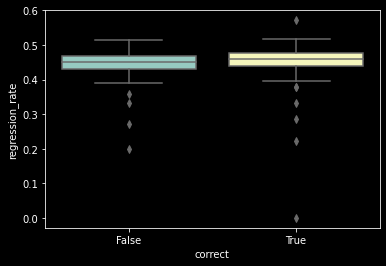

In [171]:
sns.boxplot(x="correct", y="regression_rate", data=metrics_with_correctness)

<AxesSubplot:xlabel='correct', ylabel='line_regression_rate'>

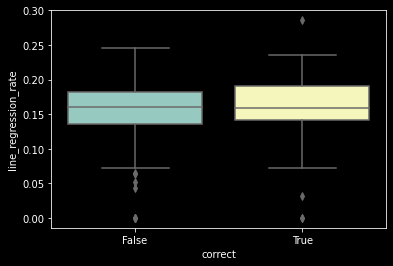

In [172]:
sns.boxplot(x="correct", y="line_regression_rate", data=metrics_with_correctness)

<AxesSubplot:xlabel='correct', ylabel='duration'>

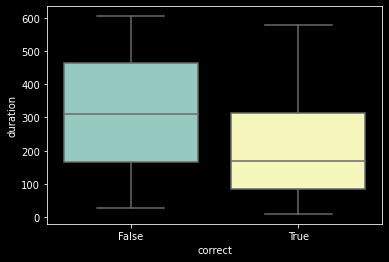

In [173]:
sns.boxplot(x="correct", y="duration", data=metrics_with_correctness)

## IVT Re-Implementation

In [200]:
sample_inputs = merged[[
    'core_time', 'x', 'y', 'source_file_line', 'source_file_col',
    'left_pupil_diameter'
]].copy()
sample_inputs.dtypes

core_time                int64
x                        int64
y                        int64
source_file_line         int64
source_file_col          int64
left_pupil_diameter    float64
dtype: object

In [203]:
sample_inputs.loc[sample_inputs['source_file_line'] == -1, 'source_file_line'] = np.nan
sample_inputs.loc[sample_inputs['source_file_col'] == -1, 'source_file_col'] = np.nan

In [209]:
sample_inputs = sample_inputs.assign(
    source_file_line=sample_inputs['source_file_line'].fillna(method='ffill'),
    source_file_col=sample_inputs['source_file_col'].fillna(method='ffill'),
)

nonnan_gaze_index = sample_inputs[~sample_inputs['source_file_line'].isna()].index

In [254]:
examples = sample_inputs.loc[nonnan_gaze_index].head(20)


def ivt(
    x: pd.Series,
    y: pd.Series,
    velocity_threshold: float = 80,
):
    # Interpolation
    x = x.where(x < 0, np.nan)
    y = y.where(y < 0, np.nan)
    x = x.fillna(method='ffill')
    y = y.fillna(method='ffill')

    is_valid = (x >= 0) & (y >= 0)

    # Compute velocity
    velocity: pd.Series = np.sqrt(x.diff()**2 + y.diff()**2).fillna(
        0)  # type: ignore
    is_fixation_point = velocity < velocity_threshold

    return (is_fixation_point !=
            is_fixation_point.shift()).cumsum(), is_fixation_point, is_valid


3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
dtype: int64

In [229]:

examples['velocity'] = np.sqrt(examples['x'].diff()**2 + examples['y'].diff()**2).fillna(0)
examples['is_fixation'] = examples['velocity'] <= 80


def ivt_fixation_filter(df: pd.DataFrame, velocity_threshold: float, duration_threshold: float,):
    pass

In [240]:
def create_fixation_groups(fixation_points, duration_threshold=80):
    fixation_duration = fixation_points['core_time'].max() - fixation_points['core_time'].min()
    if fixation_duration >= duration_threshold:
        fixation_points['duration'] = fixation_duration
        fixation_points['x'] = fixation_points['x'].mean()
        fixation_points['y'] = fixation_points['y'].mean()
        fixation_points['type'] = 'fixation'
    elif not fixation_points['is_fixation'].all():
        fixation_points['type'] = 'saccade'
    else:
        fixation_points['type'] = 'fixation_under_threshold'
    

# examples
fixation_groups = examples.groupby((examples['is_fixation'] != examples['is_fixation'].shift()).cumsum())

keys = list(fixation_groups.groups.keys())

df = fixation_groups.get_group(keys[0])

duration = df['core_time'].max() - df['core_time'].min()

duration

32

In [241]:
x = pd.Series([10, 10, 9, 9, 9, 4, 4, 2, 1])

(x != x.shift()).cumsum()

0    1
1    1
2    2
3    2
4    2
5    3
6    3
7    4
8    5
dtype: int64

In [344]:
df = pd.DataFrame([
    {'x': 2, 'y': 5},
     {'x': np.nan, 'y': 8}
])

df

,x,y
0,2.0,5
1,NaN,8


In [345]:
df.fillna(method="ffill")

,x,y
0,2.0,5
1,2.0,8


In [354]:
df.loc[df.isna().any(axis=1), :] = np.nan

In [11]:
root = pathlib.Path("/Users/devjeetroy/Library/CloudStorage/OneDrive-Personal/Control-Experiment-Spring-2022")
itrace_file = root / "p79" / "t2" / "processed-new" / "fixations.json"

# itrace_df = pd.read_xml(itrace_file, xpath=".//response")
fixations = pd.read_json(itrace_file)
fixations['system_time'] -= fixations['system_time'].min()
fixations['system_time'] = fixations['system_time'].dt.total_seconds()

In [12]:
fixations.query(
    'source_file_line >= 436 & source_file_line <= 439'
)

,duration,n,system_time,source_file_line,source_file_col,target,left_pupil_diameter,right_pupil_diameter,x,y
1,106,14,1.202,436,17,numbers_c.cc,15.846952,17.585363,542.214286,313.642857
4,179,22,2.015,436,18,numbers_c.cc,16.430132,17.739356,560.500000,305.500000
6,108,14,3.073,436,16,numbers_c.cc,16.559251,17.828699,545.571429,346.571429
7,106,13,3.197,436,14,numbers_c.cc,16.738852,18.538851,525.846154,344.615385
14,114,14,31.148,436,9,numbers_c.cc,16.725200,17.601584,497.714286,113.357143
30,171,22,70.190,436,16,numbers_c.cc,16.284526,17.551482,525.909091,56.590909
31,84,11,71.878,436,19,numbers_c.cc,16.887767,18.444415,588.000000,112.272727
